# Document Orientation Correction

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

**Download a sample Image**

In [2]:
!curl https://images.sampletemplates.com/wp-content/uploads/2016/12/21102637/Technical-Business-Document.jpg --output doc.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  177k  100  177k    0     0   238k      0 --:--:-- --:--:-- --:--:--  238k


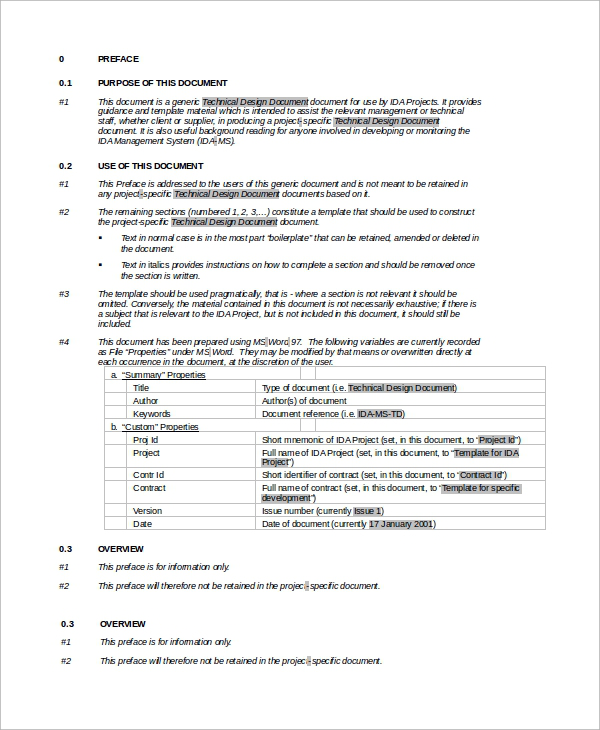

In [3]:
doc = Image.open('./doc.jpg')
doc

**We will rotate this image by 200 degrees for our demonstration**

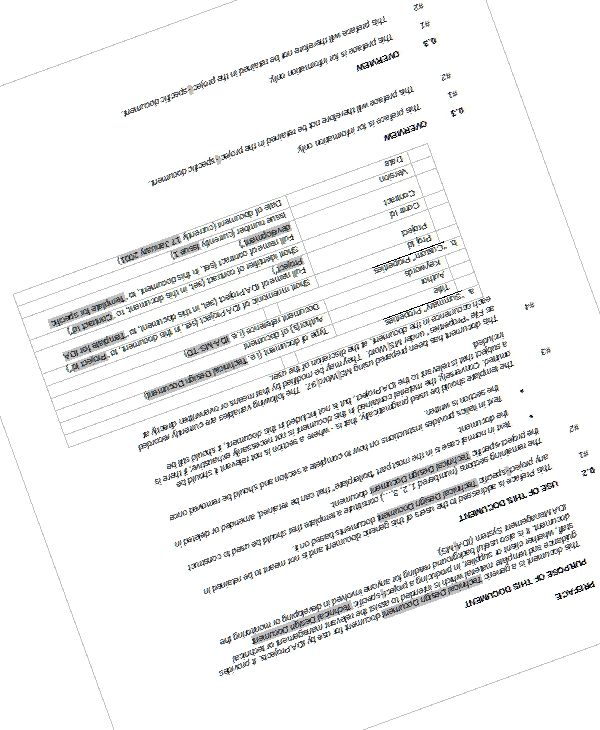

In [4]:
doc_200 = Image.open('./doc.jpg').rotate(200, fillcolor=(255, 255, 255))
doc_200

# Angle Correction
When we have an image in which the text is rotated at an unknown angle, we will:
* Binarize the image
* Calculate the minimum border containing the rotated text
* Adjust the angle: When the angle is less than – 45, add 90 degrees to the original angle, and when the angle is greater than – 45 degrees, reverse the angle directly.
* Execute affine transformation to fix the image

**This algorithm fixes the image but, sometimes it can return upside down flipped images**

In [5]:
def correct_angle(image, verbose=False):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    angle = -(90 + angle) if angle < -45 else -angle
    
    h, w = image.shape[:2]
    (c_x, c_y) = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D((c_x, c_y), angle, 1.0)
    
    cos = np.abs(matrix[0, 0])
    sin = np.abs(matrix[0, 1])
    
    n_w = int((h * sin) + (w * cos))
    n_h = int((h * cos) + (w * sin))
    
    matrix[0, 2] += (n_w / 2) - c_x
    matrix[1, 2] += (n_h / 2) - c_y
    
    return cv2.warpAffine(image, matrix, (n_w, n_h), borderValue=(255, 255, 255))

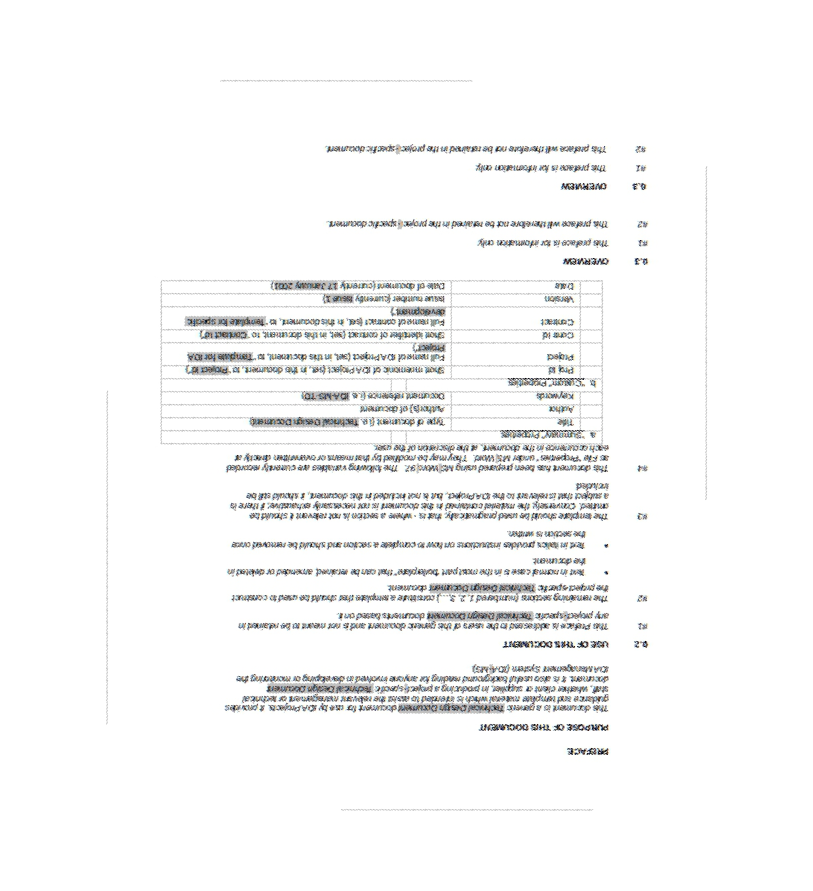

In [6]:
doc_200 = np.array(doc_200)
corrected_image = correct_angle(doc_200, True)
Image.fromarray(corrected_image)

# Flip Detection
This algorithm isbased on the assumption that the majority of the text is skewed onto one side,
The idea is that we can determine the angle based on the where the major text region is located
* Grayscale and blur the image
* Adaptive threshold to get a binary image
* Find contours and filter using contour area
* Draw filtered contours onto mask
* Count number of pixels in each half

In [7]:
def detect_flip(image, verbose=False):
    mask = np.zeros(image.shape, dtype=np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    adaptive = cv2.adaptiveThreshold(
        blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,15,4
    )

    cnts = cv2.findContours(adaptive, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        area = cv2.contourArea(c)
        if area < 45000 and area > 20:
            cv2.drawContours(mask, [c], -1, (255,255,255), -1)
            
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    h, w = mask.shape
    
    if verbose:
        fig, ax = plt.subplots(1,3, figsize=(20, 20))
        ax[0].imshow(image)
        ax[0].set_title('Original', fontsize=12)
        ax[0].axis('off')
        ax[1].imshow(adaptive, cmap='gray')
        ax[1].set_title('Thresholded', fontsize=12)
        ax[1].axis('off')
        ax[2].imshow(mask, cmap='gray')
        ax[2].set_title('Mask', fontsize=12)
        ax[2].axis('off')
        plt.show()
    
    
    left = mask[0:h, 0:0+w//2]
    right = mask[0:h, w//2:]
    left_pixels = cv2.countNonZero(left)
    right_pixels = cv2.countNonZero(right)
    return 0 if left_pixels >= right_pixels else 180

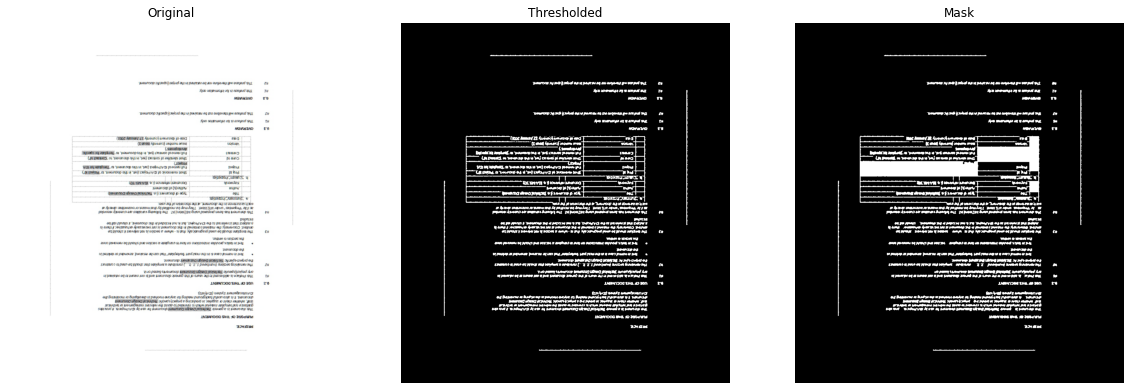

180


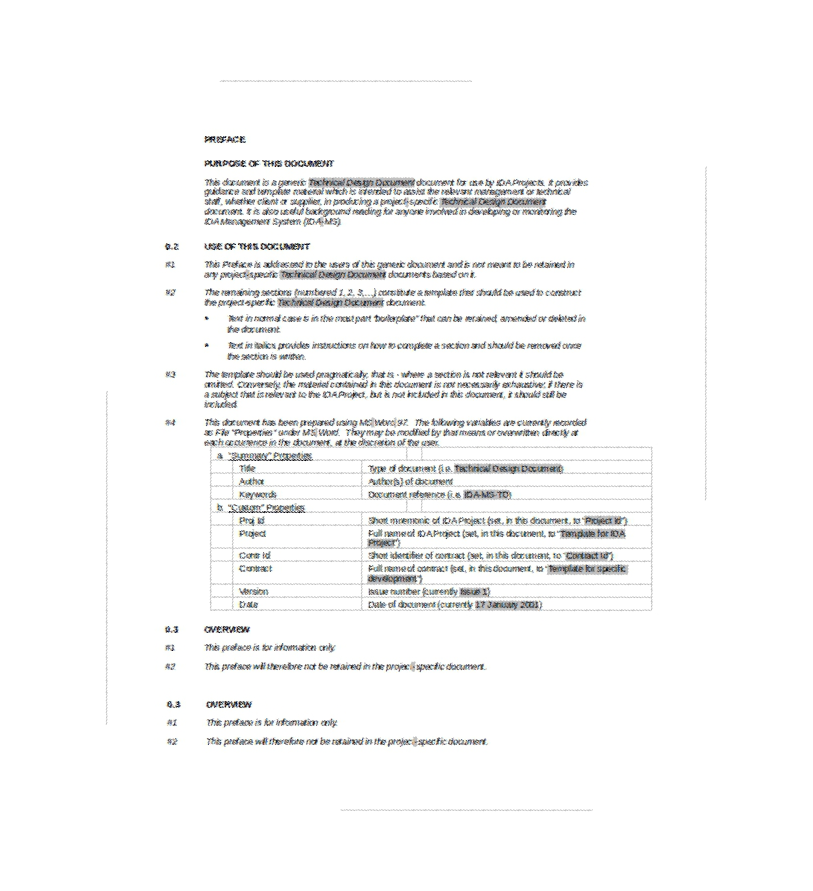

In [8]:
doc_180 = corrected_image
angle = detect_flip(doc_180, True)
print(angle)
corrected_image = Image.fromarray(corrected_image).rotate(angle)
corrected_image